# View six InSilicoICH examples (Manuscript Figure 4)
Plots six examples (two from each subtype, IPH, SDH, EDH) from a synthetic dataset.

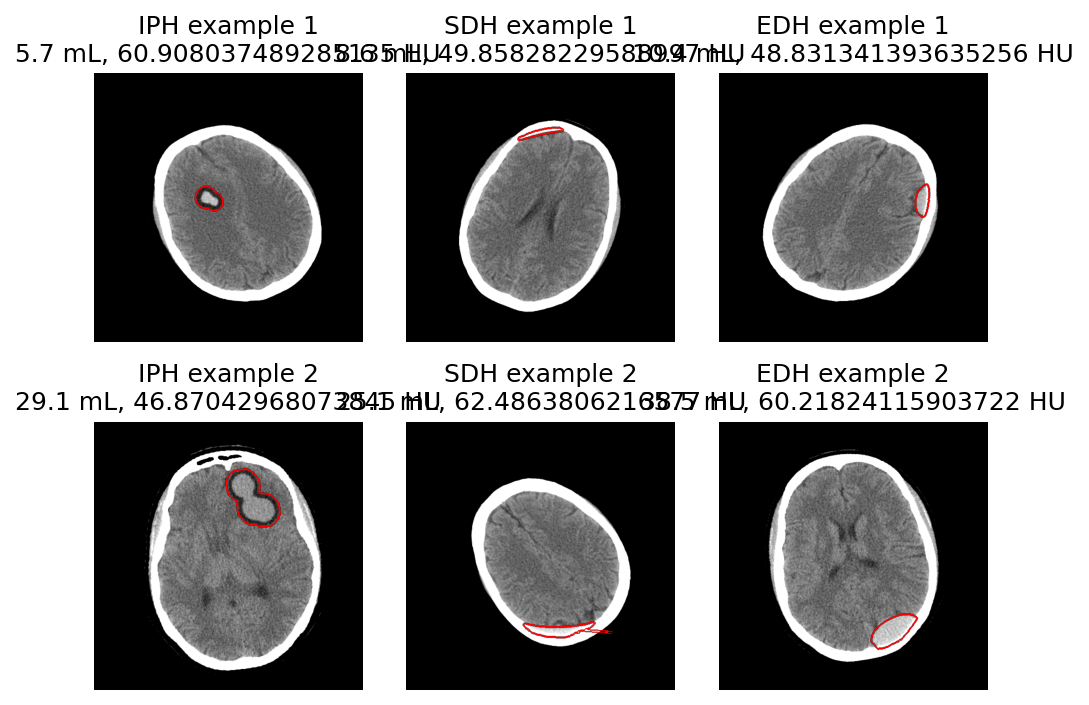

In [1]:
from image_utils import *
from pathlib import Path
import pandas as pd
import numpy as np
import skimage as ski

from insilicoICH.image_acquisition import read_dicom
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

mask_method = 'boundary' # 'boundary' or 'fill'

study_name = 'mA_280_run1'
#base_dir = Path('../datasets') / study_name
base_dir = Path('/projects01/didsr-aiml/jayse.weaver/insilicoich/') / study_name

metadata = pd.concat([pd.read_csv(o) for o in base_dir.rglob('metadata*.csv')], ignore_index=True).sort_values(by=['name', 'image file']).reset_index(drop=True)
metadata.loc[~metadata.intensity.isna(), 'lesion type'] = metadata[~metadata.intensity.isna()]['lesion type']#.apply(lambda x: x.split("['")[-1].split("']")[0])
metadata.loc[~metadata.intensity.isna(), 'intensity'] = metadata[~metadata.intensity.isna()]['intensity']#.apply(lambda x: float(x.split('[')[-1].split(']')[0])).astype(int)
metadata['image file']=metadata['image file'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))
metadata.loc[~metadata['mask file'].isna(), 'mask file']=metadata.loc[~metadata['mask file'].isna(), 'mask file'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))
metadata

for n in metadata['name'].unique():
    metadata.loc[metadata['name'] == n, 'slice'] = list(range(len( metadata[metadata['name'] == n])))
metadata['slice'] = metadata['slice'].astype(int)

metadata[~metadata.name.duplicated()]

#from utils import ctshow
window = 'brain'

# OLD FIGURE 
# cases = ['case_065', 'case_032', 'case_062'] # ROW 1: [IPH, SDH, EDH, all small]
# cases = cases + ['case_084', 'case_014', 'case_003'] # ROW 2: [IPH, SDH, EDH, larger]

# NEW FIGURE (focus on correctly identified cases)
cases = ['case_053', 'case_055', 'case_026'] # ROW 1: [IPH, SDH, EDH, all small]
cases = cases + ['case_029', 'case_072', 'case_003'] # ROW 2: [IPH, SDH, EDH, larger]

slice_averaging = True # True -> 5mm , False -> 1mm

f, axs = plt.subplots(nrows=2, ncols=3, dpi=150, tight_layout=True)
for idx, ax in enumerate(axs.flat):
    case = cases[idx]
    z = metadata[(metadata['name'] == case) & (metadata['lesion volume [mL]']>0)]['center z'].iloc[0].astype(int)
    
    if not slice_averaging:
        mask = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['mask file'].item())
        img = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['image file'].item())
    else:
        img = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z-2)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z-1)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z+1)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z+2)]['image file'].item())
        img = img/5

        mask = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['mask file'].item())

    if mask_method == 'boundary':
        labels, num = ski.measure.label(mask, background=0, connectivity=1, return_num=True)
        assert( labels.max() != 0 )
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
        mask = ski.segmentation.find_boundaries(largestCC.astype('bool'), mode='thick', background=0)
        mask = ski.segmentation.find_boundaries(mask.astype('bool'), mode='thick', background=0)
        alpha = 1.0
        cmap='bwr_r'
    else:
        # mask_method == 'fill'
        alpha = 0.5
        cmap='Reds_r'

    age =  metadata[metadata['name'] == case].iloc[z]['age'].astype(int)
    
    lesion_type = metadata[metadata['name'] == case].iloc[z]['lesion type']
    vol =  metadata[metadata['name'] == case]['lesion volume [mL]'].sum()
    intensity = metadata[metadata['name'] == case].iloc[z]['intensity']
    
    new_mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(img, cmap='gray', vmin=0, vmax=80)
    ax.imshow(new_mask, cmap=cmap, alpha=alpha)

    if lesion_type == 'round':
        lesion_type = 'IPH'
    if lesion_type == 'subdural':
        lesion_type = 'SDH'
    if lesion_type == 'epidural':
        lesion_type = 'EDH'
    if idx < 3:
        ax.set_title(f'{lesion_type} example 1\n{vol:2.1f} mL, {intensity} HU')
    else:
        ax.set_title(f'{lesion_type} example 2\n{vol:2.1f} mL, {intensity} HU')
    ax.axis("off")

# View six Hssayeni examples (Manuscript Figure ??)
Plots six examples (two from each subtype, IPH, SDH, EDH) from the independent real ICH test dataset.

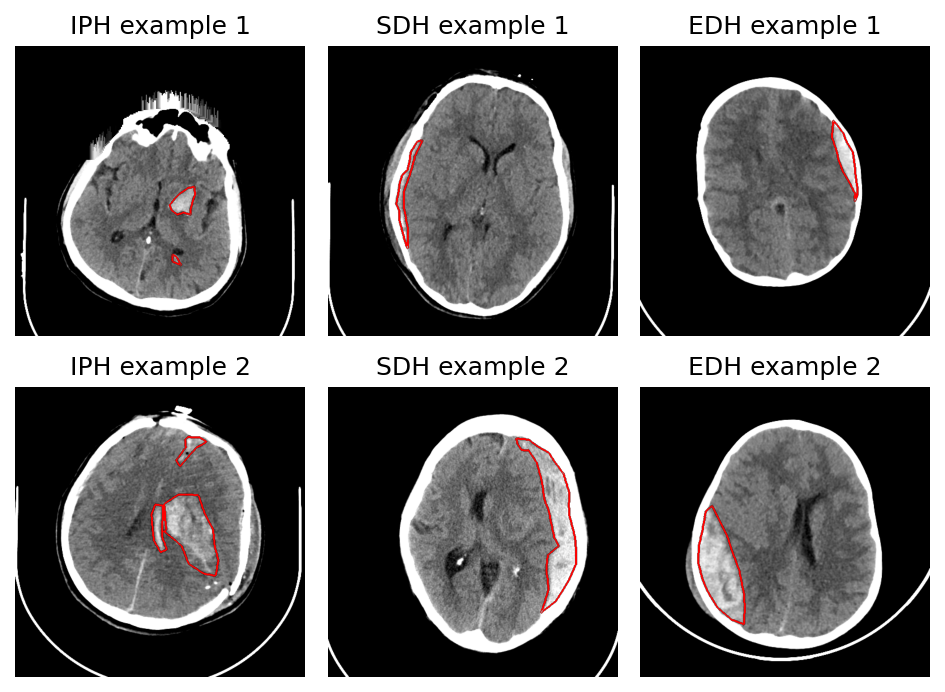

In [8]:
import sys
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski

# options
mask_method = 'boundary' # 'boundary' or 'fill'

# paths
dataset_path = '../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'
results_df = pd.read_csv('../datasets/real_dataset_predictions.csv')

# NEW FIGURE (focus on correctly identified cases)
cases = ['091', '089', '066'] # ROW 1: [IPH, SDH, EDH, all small]
cases = cases + ['094', '071', '075'] # ROW 2: [IPH, SDH, EDH, larger]

f, axs = plt.subplots(nrows=2, ncols=3, dpi=150, tight_layout=True)
for idx, ax in enumerate(axs.flat):
    case = cases[idx]

    img_vol = np.rot90(nib.load(dataset_path + '/ct_scans/' + case + '.nii').get_fdata(), 1)
    mask = np.rot90(nib.load(dataset_path + '/masks/' + case + '.nii').get_fdata(), 1)
    mask = np.where(mask > 0, 1, 0) # binarize mask
    
    # find slice with most hemorrhage voxels
    pixel_counts = []
    for i in range(mask.shape[-1]):
        pixel_counts.append(np.sum(mask[:, :, i]))

    if mask_method == 'boundary':
        mask = ski.segmentation.find_boundaries(mask[:, :, np.argmax(pixel_counts)].astype('bool'), mode='thick', background=0)
        mask = ski.segmentation.find_boundaries(mask.astype('bool'), mode='thick', background=0)
        alpha = 1.0
        cmap='bwr_r'
    else:
        # mask_method == 'fill'
        alpha = 0.5
        cmap='Reds_r'

    # plot
    new_mask = np.ma.masked_where(mask == False, mask)
    ax.imshow(img_vol[:, :, np.argmax(pixel_counts)], vmin=0, vmax=80, cmap='gray') # show img
    ax.imshow(new_mask, cmap=cmap, alpha=alpha)

    ax.axis('off')


    if lesion_type == 'round':
        lesion_type = 'IPH'
    if lesion_type == 'subdural':
        lesion_type = 'SDH'
    if lesion_type == 'epidural':
        lesion_type = 'EDH'
    
    if idx == 0:
        ax.set_title('IPH example 1')
    if idx == 1:
        ax.set_title('SDH example 1')
    if idx == 2:
        ax.set_title('EDH example 1')
    if idx == 3:
        ax.set_title('IPH example 2')
    if idx == 4:
        ax.set_title('SDH example 2')
    if idx == 5:
        ax.set_title('EDH example 2')
    # if idx < 3:
    #     ax.set_title(f'{lesion_type} example 1\n{vol:2.1f} mL, {intensity} HU')
    # else:
    #     ax.set_title(f'{lesion_type} example 2\n{vol:2.1f} mL, {intensity} HU')
    ax.axis("off")